In [1]:
%pylab inline
import pandas as pd
from IPython.display import display, HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet
reload(fastparquet)

<module 'fastparquet' from '/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/fastparquet/__init__.pyc'>

In [3]:
def read_target():
    train_test = fastparquet.ParquetFile('../input/train_test_num_v2.parq').to_pandas()
    print train_test.shape
    targets=train_test[['customer_id','market','date','target']].sort_values(['customer_id','market','date'])
    return targets.reset_index()

In [4]:
%time targets=read_target()

(6582476, 46)
CPU times: user 5.62 s, sys: 1.32 s, total: 6.94 s
Wall time: 7.3 s


In [5]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582476 entries, 0 to 6582475
Data columns (total 5 columns):
id             int64
customer_id    int64
market         float32
date           int8
target         int8
dtypes: float32(1), int64(2), int8(2)
memory usage: 138.1 MB


In [6]:
import gc
gc.collect()

10488

In [7]:
targets.tail(5)

id   customer_id    market  date  target
6582471  13707431  219009981584  4.389747     3       1
6582472  10294153  219009981584  4.658483    11       1
6582473  12584448  219009999701  4.298688     5       1
6582474  11581649  219009999701  4.298688     8       2
6582475  14160517  219009999701  4.753313     2       3

In [8]:
#import dask.dataframe as dd

In [9]:
#targets=dd.from_pandas(pd_targets,npartitions=100,sort=False)

In [10]:
#targets.head()

# make data

In [11]:
def g():
    groupedTargets =targets.groupby(['customer_id','market'])
    return [group.values.copy() for _, group in groupedTargets]

In [12]:
%time dataframes = g()

CPU times: user 6min 28s, sys: 1.1 s, total: 6min 29s
Wall time: 6min 29s


In [13]:
len(dataframes)

2566078

In [14]:
dataframes[0]

array([[  1.31251880e+07,   1.13300640e+11,   4.60082388e+00,
          4.00000000e+00,   2.00000000e+00],
       [  1.22690050e+07,   1.13300640e+11,   4.60082388e+00,
          6.00000000e+00,   4.00000000e+00]])

In [15]:
np.random.shuffle(dataframes)

In [16]:
dataframes[0]

array([[  1.36335000e+07,   1.29834697e+11,   4.61589003e+00,
          3.00000000e+00,   4.00000000e+00]])

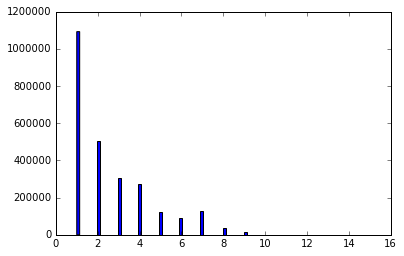

In [17]:
plt.hist([u.shape[0] for u in dataframes],bins=100);

In [18]:
import gc
gc.collect()

17289

In [19]:
def g(today, df):
    if(len(df)==0): return [np.nan]*7
    targets=df[df['target']!=-1]['target']
    latest_target=np.nan if len(targets)<1 else targets.iloc[-1]
    #latest_gap=np.nan if len(targets)<1 else today-df[df['target']!=-1].iloc[-1]['date']
    latest2_change=np.nan if len(targets)<2 else targets.iloc[-1]-targets.iloc[-2]

    count=len(targets)
    freq=count/float(df.iloc[-1]['date']+1-df.iloc[0]['date'])
    #print count, float(today-df.iloc[0]['date'])
    latest3_mean=np.nan if len(targets)<3 else np.round(targets.values[-3:].mean(),1)*10
    latest2_mean=np.nan if len(targets)<2 else np.round(targets.values[-2:].mean(),1)*10    
    changed_count=(np.diff(targets.values)!=0).sum()
    return [latest_target, count if count<11 else 11,freq,latest3_mean, \
            changed_count,latest2_change,latest2_mean]
def f(lst):
    df=pd.DataFrame(lst,columns=["id",'customer_id','market','date', 'target'])
    #df['date']=df['date'].astype(np.int8)
    #df['target']=df['target'].astype(np.int8)
    df=df.sort_values('date').reset_index(drop=True)
    lst=[]
    for i in range(len(df)):
        subdf=df.iloc[:i]
        today=df.iloc[i]['date']
        lst.append(g(today,subdf))
    
    columns=[u.strip() for u in 'latest_target,count,freq,latest3_mean,changed_count,latest2_change,latest2_mean'.split(',')]
    #print(len(columns))
    thisdf= pd.DataFrame(lst,index=df.index,columns=columns).fillna(-9999).astype(np.float32)
    
    mindate=df['date'].min()
    s=df['date']-mindate
    df['age']= (s<11)*s  +  (s >=11)*11
    
    return pd.concat([df,thisdf],axis=1).values
 

In [20]:
#import dask
#dask.set_options(get=dask.multiprocessing.get)

In [21]:
f(dataframes[0])

array([[  1.36335000e+07,   1.29834697e+11,   4.61589003e+00,
          3.00000000e+00,   4.00000000e+00,   0.00000000e+00,
         -9.99900000e+03,  -9.99900000e+03,  -9.99900000e+03,
         -9.99900000e+03,  -9.99900000e+03,  -9.99900000e+03,
         -9.99900000e+03]])

In [22]:
target_columns=["id",u'customer_id', u'market', u'date', u'target', u'age', u'latest_target',
       u'count', u'freq', u'latest3_mean', u'changed_count', u'latest2_change',
       u'latest2_mean']

In [23]:
from multiprocessing import Pool

In [24]:
p = Pool(30)

In [25]:
%time processed = p.map(f,  dataframes)

CPU times: user 29.4 s, sys: 1.63 s, total: 31 s
Wall time: 9min 42s


In [26]:
len(processed)

2566078

In [27]:
processed2=np.concatenate(processed)

In [28]:
processeddf=pd.DataFrame(processed2,columns=target_columns)

In [30]:
processeddf['customer_id']=processeddf['customer_id'].astype(np.int64)
processeddf['id']=processeddf['id'].astype(np.int64)

In [31]:
processeddf.shape

(6582476, 13)

In [32]:
processeddf.head()

id   customer_id    market  date  target  age  latest_target   count  \
0  13633500  129834697045  4.615890   3.0     4.0  0.0        -9999.0 -9999.0   
1  14605605  216808733623  4.389747   1.0     4.0  0.0        -9999.0 -9999.0   
2  10618492  133100151809  4.738487  10.0     2.0  0.0        -9999.0 -9999.0   
3    959880  133100151809  4.738487  14.0    -1.0  4.0            2.0     1.0   
4  12659105  147409415514  4.596647   5.0     6.0  0.0        -9999.0 -9999.0   

     freq  latest3_mean  changed_count  latest2_change  latest2_mean  
0 -9999.0       -9999.0        -9999.0         -9999.0       -9999.0  
1 -9999.0       -9999.0        -9999.0         -9999.0       -9999.0  
2 -9999.0       -9999.0        -9999.0         -9999.0       -9999.0  
3     1.0       -9999.0            0.0         -9999.0       -9999.0  
4 -9999.0       -9999.0        -9999.0         -9999.0       -9999.0

In [34]:
processeddf.to_csv("../input/target_processed.csv.gz",compression='gzip',index=None)

In [2]:
a=pd.read_csv("../input/target_processed.csv.gz")